## Import packages

In [50]:
import os
import pandas as pd
import numpy as np
import requests
import json
import time
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from shroomdk import ShroomDK

## API Set-up

In [2]:
# Get API_KEY from file

def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r', encoding="utf-8-sig") as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [3]:
# Get all results from query with pagination

def querying_pagination(query_string):
    sdk = ShroomDK(API_KEY)
    
    # Query results page by page and saves the results in a list
    # If nothing is returned then just stop the loop and start adding the data to the dataframe
    result_list = []
    for i in range(1,11): # max is a million rows @ 100k per page
        data=sdk.query(query_string,page_size=100000,page_number=i)
        if data.run_stats.record_count == 0:  
            break
        else:
            result_list.append(data.records)
        
    # Loops through the returned results and adds into a pandas dataframe
    result_df=pd.DataFrame()
    for idx, each_list in enumerate(result_list):
        if idx == 0:
            result_df=pd.json_normalize(each_list)
        else:
            result_df=pd.concat([result_df, pd.json_normalize(each_list)])

    return result_df

In [4]:
# Call query, save csv and return the df of a query
def query_to_df(sql_query):
    df = querying_pagination(sql_query)
    df.to_csv(f'data/{sql_query}csv', index=False) 
    return df

In [5]:
API_KEY = get_file_contents('/home/agustin/DS/Projects/NearSocialSegmentApp/keys/apikey.txt')

# Initialize `ShroomDK` with my API Key
sdk = ShroomDK(API_KEY)

In [160]:
def load_data(csv):
    df = pd.read_csv(csv)
    df['first_social_sign'] = df['first_social_sign'].astype('datetime64[ns]')
    return df.copy(deep=True)

def select_data(df, column, begin, end):
    return df[(df[column]>= np.datetime64(begin)) & (df[column]<= np.datetime64(end))]

def agg_by_column(df, column):
    return df.groupby(column).count().reset_index()

## SQL Queries

In [186]:
# New users query
auth_raw_sql = open('/home/agustin/DS/Projects/NearSocialSegmentApp/data/queries/sn_auths.txt').read()
swaps_raw_sql = open('/home/agustin/DS/Projects/NearSocialSegmentApp/data/queries/sn_swaps_act.txt').read()

users_raw_sql = open('/home/agustin/DS/Projects/NearSocialSegmentApp/data/queries/sn_users.txt').read()

## API calls

In [187]:
# Near Social auths
auth_raw_df = querying_pagination(auth_raw_sql)
auth_raw_df.to_csv('/home/agustin/DS/Projects/NearSocialSegmentApp/data/auths_raw_df.csv', index=False) 

In [127]:
# Near Social swaps
swaps_raw_df = querying_pagination(swaps_raw_sql)
swaps_raw_df.to_csv('/home/agustin/DS/Projects/NearSocialSegmentApp/data/swaps_raw_df.csv', index=False) 

In [9]:
# Near Social users
users_raw_df = querying_pagination(users_raw_sql)
users_raw_df.to_csv('/home/agustin/DS/Projects/NearSocialSegmentApp/data/users_raw_df.csv', index=False) 

In [128]:
swaps_raw_df

,tx_signer,first_social_sign,number_of_swaps,swaps_b4_social
0,rieu.near,2023-03-11 02:13:04.027,0,NEVER
1,zubairansari.near,2022-11-19 19:31:55.952,29,YES
2,harmonium.near,2022-10-09 21:27:50.018,0,NEVER
3,tedjow17.near,2023-03-04 16:39:41.588,11,YES
4,gmilescu.near,2022-12-14 19:15:02.744,0,NEVER
...,...,...,...,...
7578,moguvsev.near,2022-05-23 14:34:38.223,0,NEVER
7579,alaminh.near,2023-03-04 18:33:27.366,0,NEVER
7580,rereer.near,2023-03-11 10:29:12.754,0,NEVER
7581,alan20201.near,2023-03-05 04:57:00.642,0,NEVER


In [188]:
df1 = load_data('data/auths_raw_df.csv')
df1

,user,first_social_sign,wallet_creation,age_days,age_category,human_readable
0,4eda60bc64218550996f393104dd10d02e7d86f1a1c0ae...,2023-03-13,2023-03-13,0,SAME DAY,NO
1,truccam.near,2023-03-13,2021-11-02,496,1-2 YEARS,YES
2,90ebc31560b1de7918b0725d8fbb805f87ae6e7807ff0d...,2023-03-13,2023-03-13,0,SAME DAY,NO
3,0eafbd584724d3142b1d88e10fc74d1e2cafef8efa5e7f...,2023-03-13,2023-02-22,19,0-3 MONTHS,NO
4,alexsumon56.near,2023-03-13,2022-09-04,190,6-12 MONTHS,YES
...,...,...,...,...,...,...
7578,rucommunity.near,2022-02-18,2021-04-06,318,6-12 MONTHS,YES
7579,kotleta.near,2022-02-17,2021-06-01,261,6-12 MONTHS,YES
7580,aliaksandrh.near,2022-02-17,2020-09-13,522,1-2 YEARS,YES
7581,vlad.near,2022-02-17,2020-07-31,566,1-2 YEARS,YES


In [183]:
df2 = select_data(df1, 'first_social_sign' , begin_date, end_date)
df3 = agg_by_column(df2[['user', 'age_category']], 'age_category').rename({'user': 'wallets'}, axis=1)
df3

,age_category,wallets
0,1-2 YEARS,55
1,3-6 MONTHS,24
2,6-12 MONTHS,40
3,LESS THAN 3 MONTHS,35
4,MORE THAN 2 YEARS,4
5,SAME DAY SIGNER,226


In [185]:
df555 = df2[['user', 'age_category', 'human_readable']].groupby(['age_category', 'human_readable']).count()
df555

user
age_category       human_readable      
1-2 YEARS          NO                 2
                   YES               53
3-6 MONTHS         NO                11
                   YES               13
6-12 MONTHS        NO                10
                   YES               30
LESS THAN 3 MONTHS NO                 9
                   YES               26
MORE THAN 2 YEARS  NO                 1
                   YES                3
SAME DAY SIGNER    NO                42
                   YES              184

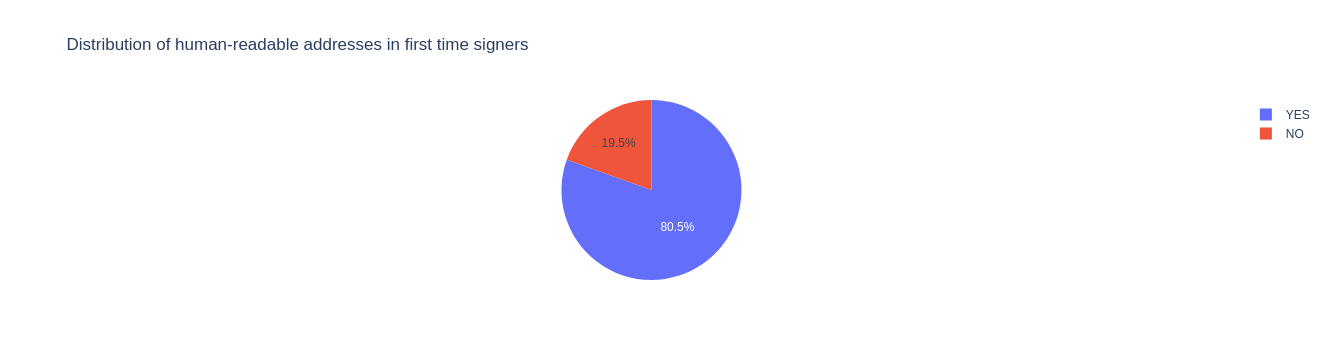

In [178]:
fig = px.pie(df3, values='wallets', names='human_readable', title='Distribution of human-readable addresses amongst first time signers')
fig.show()

In [150]:
df1.groupby('first_social_sign').count().reset_index().rename({'first_social_sign': 'Date', 'user':'Daily Users'}, axis=1)

,Date,Daily Users
0,2022-02-16,1
1,2022-02-17,3
2,2022-02-18,1
3,2022-02-19,4
4,2022-02-20,47
...,...,...
220,2023-03-09,109
221,2023-03-10,112
222,2023-03-11,171
223,2023-03-12,70


In [152]:
df1 = auth_raw_df.copy(deep=True)[['user', 'first_social_sign']]

df1['time'] = df1['first_social_sign'].astype('datetime64[ns]')
df2 = df1.count()[['user']].reset_index().rename({'time': 'Date', 'user':'Daily Users'}, axis=1)
df2

,index,0
0,user,7583


In [87]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         391 non-null    datetime64[ns]
 1   Daily Users  391 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB


In [116]:
begin_date = datetime.date(2023,2,24)
end_date = datetime.date(2023,3,1)
type(begin_date)

datetime.date

In [118]:
df3 = df2[(df2['Date']>= np.datetime64(begin_date)) & (df2['Date']<= np.datetime64(end_date))]
df3

,Date,Daily Users
373,2023-02-24,63
374,2023-02-25,66
375,2023-02-26,45
376,2023-02-27,73
377,2023-02-28,27
378,2023-03-01,110


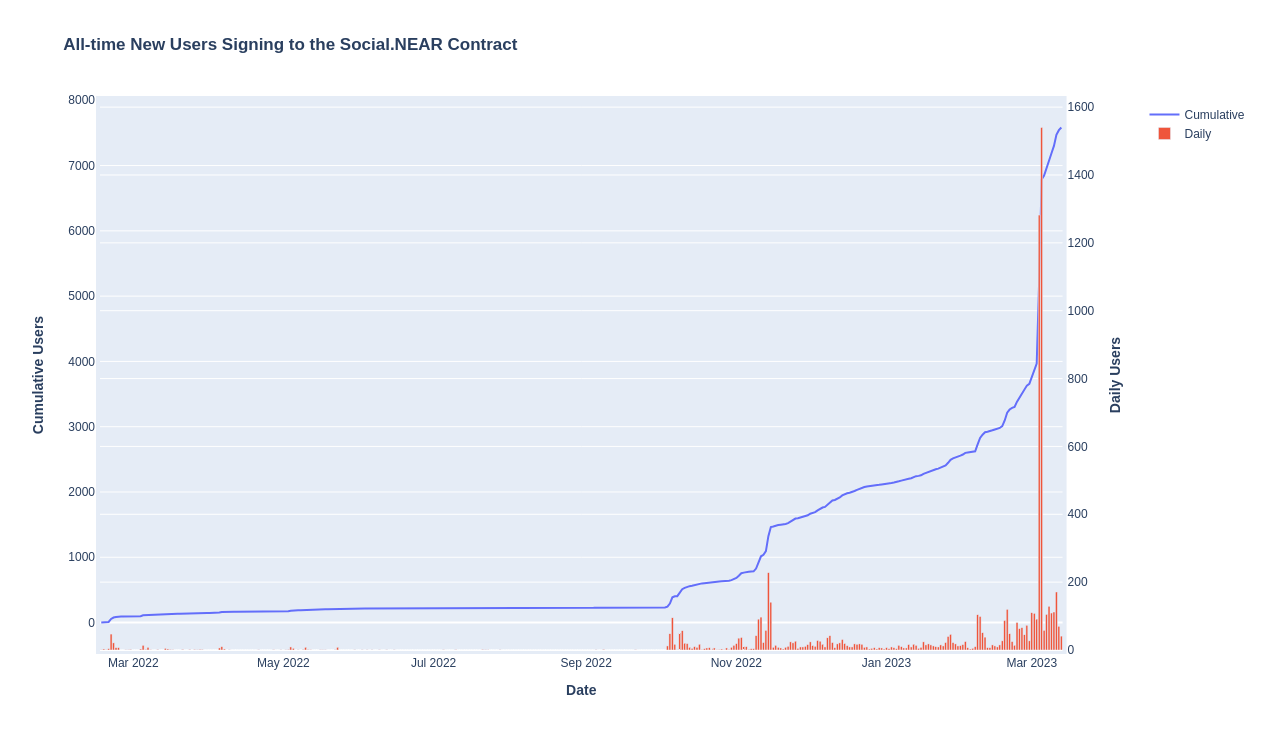

In [78]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
#fig=go.Figure()

fig.add_trace(
    go.Scatter(x=df2['Date'], y=df2['Daily Users'].cumsum(), name='Cumulative'),
    secondary_y=False
    )

fig.add_trace(
    go.Bar(x=df2['Date'], y=df2['Daily Users'], name='Daily'),
    secondary_y=True
    )

# Set x-axis title
fig.update_xaxes(title_text="<b>Date</b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Cumulative Users</b> ", secondary_y=False)

fig.update_yaxes(title_text="<b>Daily Users</b> ", secondary_y=True)

fig.update_layout(
    title='<b>All-time New Users Signing to the Social.NEAR Contract</b>',
    autosize=False,
    width=1000,
    height=750,
    margin=dict(
        l=100,
        r=100,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="white",
    hovermode='x unified'
)

fig.show()

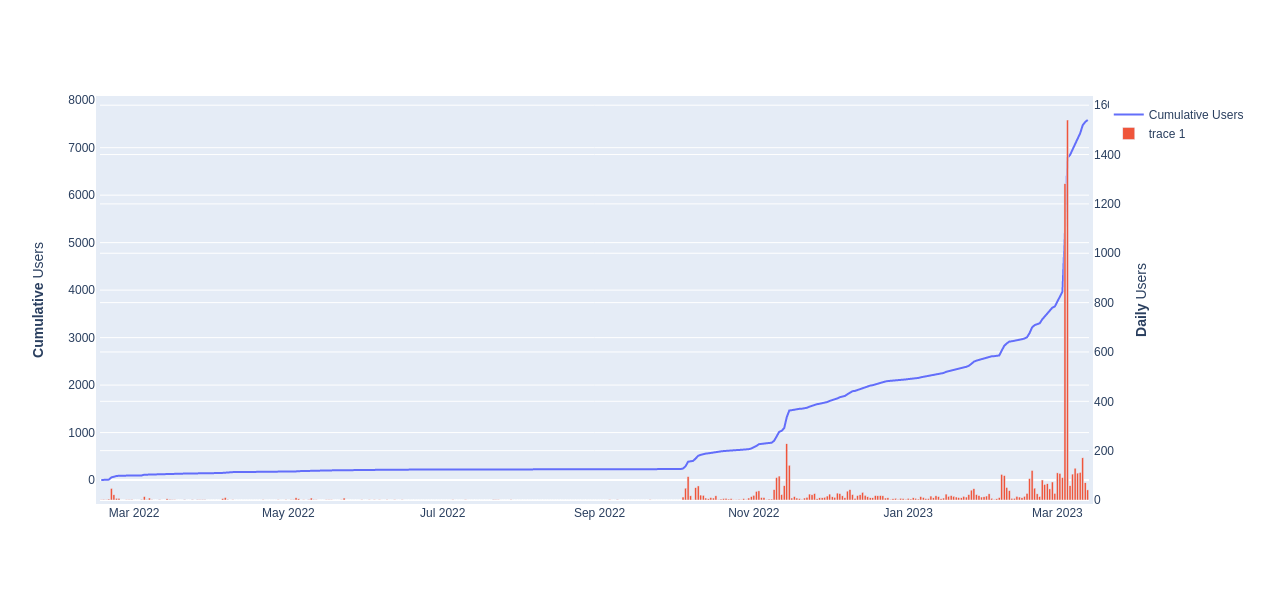

In [70]:
#fig = make_subplots(specs=[[{'secondary_y': True}]])
fig=go.Figure()

fig.add_trace(
    go.Scatter(x=df2['Date'], y=df2['Cumulative Users'], name='Cumulative Users')
    )

fig.add_trace(
    go.Bar(x=df2['Date'], y=df2['Daily Users'], yaxis='y2')
    )

fig.update_layout(autosize=False,
                  width=800,
                  height=600,
                  margin=dict(l=100,
                              r=100,
                              b=100,
                              t=100,
                              pad=4
                             ),
                  paper_bgcolor='white',
                  #xaxis=dict(text='Date'),
                  yaxis=dict(title='<b>Cumulative</b> Users',
                             side='left'
                            ),
                  yaxis2=dict(title='<b>Daily</b> Users',
                              side='right',
                              overlaying='y',
                              tickmode='auto'
                             )
                 )

fig.show()

In [46]:
fig = px.line(df2, x='Date', y='Cumulative Users')

fig.add_bar(df2, x='Date', y='Daily Users', alignmentgroup=0)

fig.show()

TypeError: add_bar() got multiple values for argument 'alignmentgroup'

### Data Processing

In [85]:
# SQL Query output with 7048 rows
u2u_act_df.head(2)

,block_timestamp,tx_hash,user_name,index
0,2022-11-28 19:17:08.034,FKM3pkgMbvH3xgJ5spXUALugBaHwFjzd79ZDrFPFK7Zc,nonsense.near,"{""key"":""aliaksandrh.near"",""value"":{""type"":""fol..."
1,2022-11-28 19:17:15.899,5QdotQGwRNaw9d5BuaB1iikufzEQhZK9vYBqEqRe5ESQ,nonsense.near,"{""key"":""vlad.near"",""value"":{""type"":""follow""}}"


In [84]:
# Index Null 
u2u_act_df[u2u_act_df['index'].isnull()]

,block_timestamp,tx_hash,user_name,index
2313,2022-12-16 21:10:55.728,8yWsaCWZixNvpUMtBumZU1nKu1iJGDUy8zGND2BZ7vxD,webuidl.near,None


In [86]:
# SQL with cleaned indeces (7047)
u2u_act_clean_df = u2u_act_df.dropna()
u2u_act_clean_df.head(5)

,block_timestamp,tx_hash,user_name,index
0,2022-11-28 19:17:08.034,FKM3pkgMbvH3xgJ5spXUALugBaHwFjzd79ZDrFPFK7Zc,nonsense.near,"{""key"":""aliaksandrh.near"",""value"":{""type"":""fol..."
1,2022-11-28 19:17:15.899,5QdotQGwRNaw9d5BuaB1iikufzEQhZK9vYBqEqRe5ESQ,nonsense.near,"{""key"":""vlad.near"",""value"":{""type"":""follow""}}"
2,2022-11-28 18:53:52.579,3JvJPVP2voz5ZDd5dCQwcmDPXQnBFqy1aScUoHVLFhQc,haenko.near,"{""key"":""rimberjack.near"",""value"":{""type"":""foll..."
3,2022-11-28 18:37:32.472,HEpwoh8CqLGNoTTw6YCGaCs4oQdz1mfAr1z4wsVYJ8Z1,aliaksandrh.near,"{""key"":""mob.near"",""value"":{""type"":""follow""}}"
4,2022-11-28 19:19:49.213,5VinAyNdKMv2B2jmQcwfPTmwGgBECJbz8avkMnAgK2Yz,nonsense.near,"{""key"":""flmel.near"",""value"":{""type"":""follow""}}"


In [100]:
# There are some indexes with one dict pair (receiver - action) and some with multiple pairs.
# I will separate them to preprocess them differently
u2u_flatten_df = u2u_act_clean_df.join(u2u_act_clean_df['index'].apply(json.loads).apply(pd.Series));
u2u_1p_df = u2u_flatten_df[u2u_flatten_df[0].isnull()] # 6913 rows
u2u_mp_df = u2u_flatten_df[u2u_flatten_df[0].notnull()] # 134 rows 

/tmp/ipykernel_4838/446209063.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  u2u_flatten_df = u2u_act_clean_df.join(u2u_act_clean_df['index'].apply(json.loads).apply(pd.Series));
/tmp/ipykernel_4838/446209063.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  u2u_flatten_df = u2u_act_clean_df.join(u2u_act_clean_df['index'].apply(json.loads).apply(pd.Series));
/tmp/ipykernel_4838/446209063.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  u2u_flatten_df = u2u_act_clean_df.join(u2u_act_clean_df['index'].apply(json.loads).apply(pd.Series));
/tmp/ipykernel_4838/446209063.py:3: FutureWarning: The default dtype for empty Series will be 'ob

In [123]:
u2u_1p_clean_df = u2u_1p_df[u2u_1p_df['key'].notnull()][['block_timestamp', 
                                                          'tx_hash', 
                                                          'user_name', 
                                                          'key', 
                                                          'value']]

u2u_1p_clean_df.info()                                  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6887 entries, 0 to 7047
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   block_timestamp  6887 non-null   object
 1   tx_hash          6887 non-null   object
 2   user_name        6887 non-null   object
 3   key              6887 non-null   object
 4   value            6887 non-null   object
dtypes: object(5)
memory usage: 322.8+ KB


In [131]:
#u2u_1p_clean_df.join(u2u_1p_clean_df['value'].apply(json.loads).apply(pd.Series))     
u2u_1p_flatten_df = u2u_1p_clean_df.join(pd.json_normalize(u2u_1p_clean_df['value']))

u2u_1p_flatten_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6887 entries, 0 to 7047
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   block_timestamp   6887 non-null   object 
 1   tx_hash           6887 non-null   object 
 2   user_name         6887 non-null   object 
 3   key               6887 non-null   object 
 4   value             6887 non-null   object 
 5   type              6686 non-null   object 
 6   item.type         1727 non-null   object 
 7   item.path         1727 non-null   object 
 8   item.blockHeight  1726 non-null   float64
 9   stateData         1 non-null      object 
 10  who               1 non-null      object 
 11  post              1 non-null      float64
dtypes: float64(2), object(10)
memory usage: 957.5+ KB


In [133]:
# There are 201 rows that give a type NULL and won't be considered
u2u_1p_flatten_df[u2u_1p_flatten_df['type'].isnull()]

,block_timestamp,tx_hash,user_name,key,value,type,item.type,item.path,item.blockHeight,stateData,who,post
2108,2022-11-27 10:39:47.633,6RFa89izbeyBW7bPp2Uz8QPgx5x28JTkoroMxsWybrPZ,web3hedge.near,alejandro.near,{'type': 'follow'},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2677,2022-12-17 02:59:41.304,FxViryvKwHgUYJeJxPRHh8g8gbUx39wLg5Qi4XBYsE6y,johanga108.near,alejandro.near,{'type': 'follow'},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2678,2022-12-17 03:05:18.514,DYQejW5iJfq6HySeRZLj5PjjgwUbn7jcRBhkrqXVNSUi,chloe.near,zavodil.near,{'type': 'follow'},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2682,2022-12-23 00:24:13.105,8MkBNdfaKcQwjVALea79HyCHbZ9vyLZPt7FuLR24Nv5j,mooob.near,chefsale.near,"{'type': 'like', 'item': {'type': 'social', 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3090,2023-01-24 15:07:51.317,4up6Vy54V9tTxZgf9VncoaxxkngZp4uKpwqfpDaqJaou,ibmm.near,nate.near,{'type': 'poke'},NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7043,2023-01-20 14:10:32.719,CuAwXyZ83i5nfWtcEj2cxyyNPs8Bmo6H1Ddo5AVATxvJ,nearmultiverse.near,nearweek-news-contribution.sputnik-dao.near,"{'type': 'like', 'item': {'type': 'social', 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7044,2023-01-20 12:20:17.979,FGXCPfXLQzSHQRGqPvKo67fjv4FwpEDhnZvQAvMFMec3,jeanrocha.near,alejandro.near,{'type': 'poke'},NaN,NaN,NaN,NaN,NaN,NaN,NaN
7045,2023-01-20 12:53:04.714,EwV8EUJLxtgWp2EG9K9x3N7ZcbwdpW7jmY6L8PG6TR74,readylayerone.near,cudam321.near,"{'type': 'like', 'item': {'type': 'social', 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7046,2023-01-20 13:29:26.139,2ogp8t3i1qceDixxJFzT1qWBRqAsj4xLqjZqAM9SndAj,scottie.near,nearweek-news-contribution.sputnik-dao.near,"{'type': 'like', 'item': {'type': 'social', 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
u2u_1p_flatten_2_df = u2u_1p_flatten_df[u2u_1p_flatten_df['type'].notnull()]
u2u_1p_flatten_2_df
#u2u_1p_flatten_2_df[(u2u_1p_flatten_2_df['type']!='like') & (u2u_1p_flatten_2_df['item.type'].notnull())]

,block_timestamp,tx_hash,user_name,key,value,type,item.type,item.path,item.blockHeight,stateData,who,post
0,2022-11-28 19:17:08.034,FKM3pkgMbvH3xgJ5spXUALugBaHwFjzd79ZDrFPFK7Zc,nonsense.near,aliaksandrh.near,{'type': 'follow'},follow,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-28 19:17:15.899,5QdotQGwRNaw9d5BuaB1iikufzEQhZK9vYBqEqRe5ESQ,nonsense.near,vlad.near,{'type': 'follow'},follow,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-28 18:53:52.579,3JvJPVP2voz5ZDd5dCQwcmDPXQnBFqy1aScUoHVLFhQc,haenko.near,rimberjack.near,{'type': 'follow'},follow,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-28 18:37:32.472,HEpwoh8CqLGNoTTw6YCGaCs4oQdz1mfAr1z4wsVYJ8Z1,aliaksandrh.near,mob.near,{'type': 'follow'},follow,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-28 19:19:49.213,5VinAyNdKMv2B2jmQcwfPTmwGgBECJbz8avkMnAgK2Yz,nonsense.near,flmel.near,{'type': 'follow'},follow,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6882,2022-12-14 05:28:35.909,DuMDpbQr7u1E3axAauAsUzY6CYYxx1T2S8bVMSJVrtYZ,duocelot.near,andyh.near,{'type': 'follow'},like,social,nearweek-news-contribution.sputnik-dao.near/po...,83382189.0,NaN,NaN,NaN
6883,2022-12-30 00:46:18.703,Dh6uHMKR9VgivCToDbGnCRXiwftGorrRBNFB5tYCe5jP,johanga108.near,microchipgnu.near,{'type': 'follow'},poke,NaN,NaN,NaN,NaN,NaN,NaN
6884,2023-01-10 23:45:44.129,DYsa6HFT2aLjjKDExiNwCkQmH6ZgYffgahKLVrVJQyzA,blckhntr.near,miraclx.near,{'type': 'follow'},like,social,cudam321.near/post/main,83379069.0,NaN,NaN,NaN
6885,2023-01-10 17:36:35.089,A67pw7egp2ZwKfVQkpzsGch4J7NAd8gxm3zHXVyehAVL,keyokey.near,root.near,"{'type': 'like', 'item': {'type': 'social', 'p...",like,social,nearweek-news-contribution.sputnik-dao.near/po...,83382189.0,NaN,NaN,NaN


In [159]:
u2u_graph_interactions_df = u2u_1p_flatten_2_df[['block_timestamp',
                                                 'tx_hash',
                                                 'user_name',
                                                 'key',
                                                 'type',
                                                 'item.type',
                                                 'item.path'                                                 
                                                ]].rename({'key': 'receiver', 
                                                           'type': 'interaction',
                                                           'item.type': 'interaction_subtype',
                                                           'item.path': 'interaction_object'
                                                          }, axis=1)  # new method
u2u_graph_interactions_df

,block_timestamp,tx_hash,user_name,receiver,interaction,interaction_subtype,interaction_object
0,2022-11-28 19:17:08.034,FKM3pkgMbvH3xgJ5spXUALugBaHwFjzd79ZDrFPFK7Zc,nonsense.near,aliaksandrh.near,follow,NaN,NaN
1,2022-11-28 19:17:15.899,5QdotQGwRNaw9d5BuaB1iikufzEQhZK9vYBqEqRe5ESQ,nonsense.near,vlad.near,follow,NaN,NaN
2,2022-11-28 18:53:52.579,3JvJPVP2voz5ZDd5dCQwcmDPXQnBFqy1aScUoHVLFhQc,haenko.near,rimberjack.near,follow,NaN,NaN
3,2022-11-28 18:37:32.472,HEpwoh8CqLGNoTTw6YCGaCs4oQdz1mfAr1z4wsVYJ8Z1,aliaksandrh.near,mob.near,follow,NaN,NaN
4,2022-11-28 19:19:49.213,5VinAyNdKMv2B2jmQcwfPTmwGgBECJbz8avkMnAgK2Yz,nonsense.near,flmel.near,follow,NaN,NaN
...,...,...,...,...,...,...,...
6882,2022-12-14 05:28:35.909,DuMDpbQr7u1E3axAauAsUzY6CYYxx1T2S8bVMSJVrtYZ,duocelot.near,andyh.near,like,social,nearweek-news-contribution.sputnik-dao.near/po...
6883,2022-12-30 00:46:18.703,Dh6uHMKR9VgivCToDbGnCRXiwftGorrRBNFB5tYCe5jP,johanga108.near,microchipgnu.near,poke,NaN,NaN
6884,2023-01-10 23:45:44.129,DYsa6HFT2aLjjKDExiNwCkQmH6ZgYffgahKLVrVJQyzA,blckhntr.near,miraclx.near,like,social,cudam321.near/post/main
6885,2023-01-10 17:36:35.089,A67pw7egp2ZwKfVQkpzsGch4J7NAd8gxm3zHXVyehAVL,keyokey.near,root.near,like,social,nearweek-news-contribution.sputnik-dao.near/po...


In [213]:
u2u_graph_interactions_df[u2u_graph_interactions_df['interaction']=='unfollow']

,block_timestamp,tx_hash,user_name,receiver,interaction,interaction_subtype,interaction_object
26,2022-12-15 16:18:45.661,7z6TBvYuCxDURSXiLwN74ZKKZVnYTo2uPdPpyA92wrxe,jlw.near,0_o.starpause.near,unfollow,NaN,NaN
50,2022-12-20 20:23:21.366,BfG4SZtoeRHYhfSoHHg39EDCWaZEMw45wkHnC9qgdRQB,loonynvi.near,billybones.near,unfollow,NaN,NaN
96,2022-12-08 09:40:40.291,D8mfcnWcS7AoRqnJNfBrtAahKprjghQxJkaAnSj2wPJm,luluca_l.near,daorecords.near,unfollow,NaN,NaN
97,2022-12-08 09:38:17.851,12oATeBr3yZs6j6tpSZXBTYLNKtfshuWAtTvQkXRXFGp,luluca_l.near,infinity.near,unfollow,NaN,NaN
98,2022-12-08 09:39:25.766,J82FoCX55WkszByTg1MsqxLYVMPkDRk5HgYxiq8wj6XG,luluca_l.near,playonnear.near,unfollow,NaN,NaN
...,...,...,...,...,...,...,...
6237,2023-01-23 09:22:55.661,8nCcBEar8LFiVimYAXckgp5Pe7Q7dWcRhWGSJZWs748Z,cudam321.near,cacossio.near,unfollow,NaN,NaN
6481,2023-01-18 10:42:35.074,F5nEAyhztpKjU1GL56gQXR7BFkPqL5yd5mBKND1QRcT6,patrick.near,nearmultiverse.near,unfollow,NaN,NaN
6562,2023-01-22 16:47:38.549,hea6HkgmnV3uNNQoBGHAFHTTDn1jgfYgn2wUnQepmyy,toolipse.near,chefsale.near,unfollow,NaN,NaN
6733,2023-01-03 16:40:11.762,46MJcqqWx3b7GojqLWT3C7sdgV6Rj2vyc9AYL69UGCWz,williamxx.near,blaze.near,unfollow,NaN,NaN


In [217]:
following_count_df = u2u_graph_interactions_df[
    u2u_graph_interactions_df['interaction']=='follow'].groupby(
    ['user_name']).size().reset_index(name='following').sort_values(by=['following'], 
                                                                    ascending=False)

followers_count_df = u2u_graph_interactions_df[
    u2u_graph_interactions_df['interaction']=='follow'].groupby(
    ['receiver']).size().reset_index(name='followers').sort_values(by=['followers'], 
                                                                    ascending=False)

notfollowing_count_df = u2u_graph_interactions_df[
    u2u_graph_interactions_df['interaction']=='unfollow'].groupby(
    ['user_name']).size().reset_index(name='unfollowing').sort_values(by=['unfollowing'], 
                                                                    ascending=False)

notfollowers_count_df = u2u_graph_interactions_df[
    u2u_graph_interactions_df['interaction']=='unfollow'].groupby(
    ['receiver']).size().reset_index(name='unfollowers').sort_values(by=['unfollowers'], 
                                                                    ascending=False)

users_list = pd.concat([u2u_graph_interactions_df['user_name'], u2u_graph_interactions_df['receiver']], ignore_index=True, sort=False)
users_df = pd.DataFrame(pd.unique(users_list), columns=['users'])

following_count_df.shape, followers_count_df.shape, notfollowing_count_df.shape, notfollowers_count_df.shape

((395, 2), (444, 2), (53, 2), (52, 2))

In [220]:
notfollowers_count_df['unfollowers'].sum(), notfollowing_count_df['unfollowing'].sum(), 

(68, 68)

In [226]:
user_ff_df = users_df.join(
    following_count_df.set_index('user_name'), on='users'
    ).join(
    notfollowing_count_df.set_index('user_name'), on='users'
    ).join(
    followers_count_df.set_index('receiver'), on='users'
    ).join(
    notfollowers_count_df.set_index('receiver'), on='users'
    ).fillna(value=0)

float_col = user_ff_df.select_dtypes(include=['float64'])

for col in float_col.columns.values:
    user_ff_df[col] = user_ff_df[col].astype('int64')
    
user_ff_df['net_following'] = user_ff_df['following'] - user_ff_df['unfollowing']
user_ff_df['net_followers'] = user_ff_df['followers'] - user_ff_df['unfollowers']

user_ff_df.sort_values(by=['following', 'followers'], ascending=False)

,users,following,unfollowing,followers,unfollowers,net_following,net_followers
73,duocelot.near,149,3,88,2,146,86
19,mob.near,96,3,146,1,93,145
75,cronus.near,75,0,55,2,75,53
22,alejandro.near,74,1,70,1,73,69
81,bancambios.near,74,0,24,0,74,24
...,...,...,...,...,...,...,...
582,baseddeeegen.near,0,0,0,0,0,0
583,valar999.near,0,0,0,0,0,0
584,benipsen.near,0,0,0,0,0,0
588,remziemrekahveci.near,0,0,0,0,0,0


## Cleaned Data

### Following - Followers stats per user

In [230]:
following_followers_df = user_ff_df[
    ['users', 'net_following', 'net_followers']
    ].sort_values(by=['net_following', 'net_followers'], ascending=False)
following_followers_df

,users,net_following,net_followers
73,duocelot.near,146,86
19,mob.near,93,145
75,cronus.near,75,53
81,bancambios.near,74,24
22,alejandro.near,73,69
...,...,...,...
583,valar999.near,0,0
584,benipsen.near,0,0
588,remziemrekahveci.near,0,0
597,project438.near,0,0


### Poke Activity

In [260]:
pokes_df = u2u_graph_interactions_df[u2u_graph_interactions_df['interaction']=='poke'].sort_values(
    by=['block_timestamp'], ascending=False)

pokes_df['poke'] = '\U0001F448'

pokes_df['timediff'] = pd.Timestamp.utcnow() - pd.to_datetime(pokes_df['block_timestamp'],utc=True)
#pokes_df['hours_ago'] = pokes_df['timediff'].strftime('%d %X')

poke_activity_df = pokes_df[['receiver', 'poke', 'user_name', 'timediff']]
poke_activity_df

,receiver,poke,user_name,timediff
6523,hatchet.near,👈,kenjon.near,0 days 11:24:42.215172
6568,hatchet.near,👈,kenjon.near,0 days 11:33:28.151172
5965,nearweek-news-contribution.sputnik-dao.near,👈,hackerhouse.near,0 days 12:20:28.445172
5272,blaze.near,👈,hackerhouse.near,0 days 12:27:59.131172
5855,rin.akaia.near,👈,nearindiahub.near,0 days 15:31:57.602172
...,...,...,...,...
683,rimberjack.near,👈,mob.near,63 days 02:07:57.196172
682,alejandro.near,👈,mob.near,63 days 02:08:33.921172
770,riqi.near,👈,mob.near,63 days 02:10:56.103172
678,whendacha.near,👈,cronus.near,63 days 02:31:24.166172


### Follow activity

In [269]:
follows_df = u2u_graph_interactions_df[u2u_graph_interactions_df['interaction']=='follow'].sort_values(
    by=['block_timestamp'], ascending=False)

follows_df['description'] = 'followed'

follows_df['timediff'] = pd.Timestamp.utcnow() - pd.to_datetime(follows_df['block_timestamp'],utc=True)
#pokes_df['hours_ago'] = pokes_df['timediff'].strftime('%d %X')

follow_activity_df = follows_df[['user_name', 'description', 'receiver', 'timediff']]
follow_activity_df

,user_name,description,receiver,timediff
6524,kenjon.near,followed,hatchet.near,0 days 11:29:32.227018
5966,toolipse.near,followed,onboarder.near,0 days 11:33:45.477018
4886,vikk.near,followed,raicholime.near,0 days 11:40:52.690018
6297,hackerhouse.near,followed,davidmo.near,0 days 12:26:57.747018
6268,toolipse.near,followed,nearindiahub.near,0 days 14:36:32.026018
...,...,...,...,...
680,whendacha.near,followed,johanga108.near,63 days 02:39:59.422018
3500,whendacha.near,followed,mob.near,63 days 02:40:15.127018
1684,whendacha.near,followed,zavodil.near,63 days 02:41:40.301018
3501,max_p.near,followed,whendacha.near,63 days 02:43:40.972018


## Visualizations

In [166]:
interactions_count_df = u2u_graph_interactions_df.groupby(['interaction']).size().reset_index(name='counts').sort_values(by=['counts'], 
                                                                                                                         ascending=False)
interactions_count_df

,interaction,counts
2,follow,3903
3,like,1538
4,poke,985
0,comment,189
6,unfollow,68
5,state-transition,2
1,devgovgigs/like,1


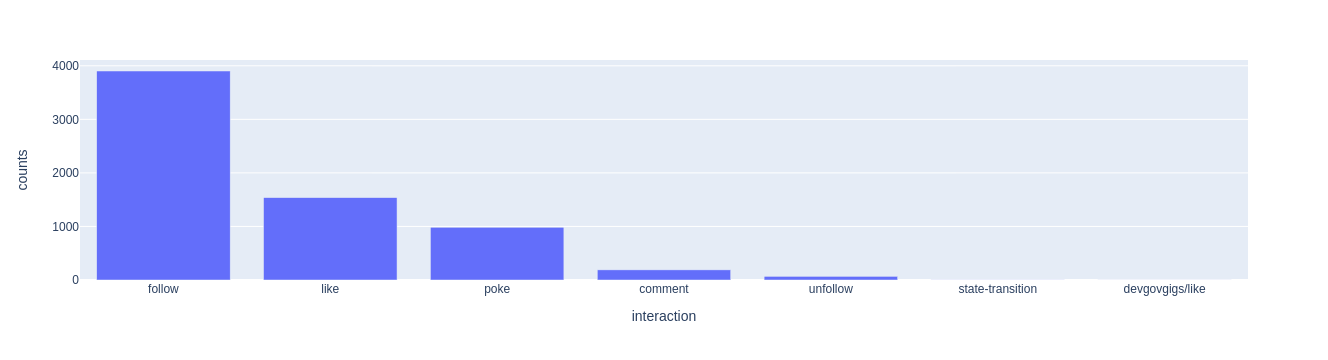

In [168]:
fig = px.bar(interactions_count_df, x='interaction', y='counts')
fig.show()

## BACKUP

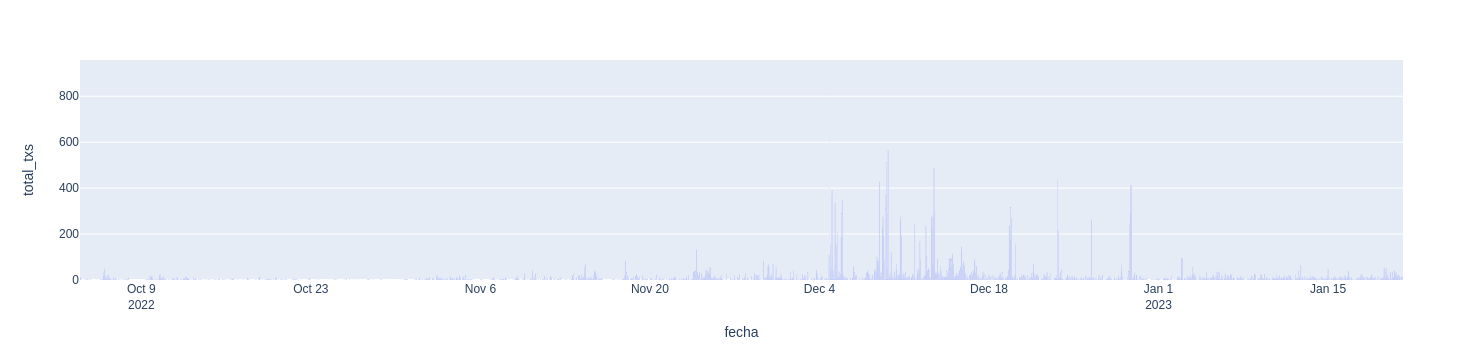

In [83]:
fig = px.bar(txs_by_hour_df, x='fecha', y='total_txs')
fig.show()

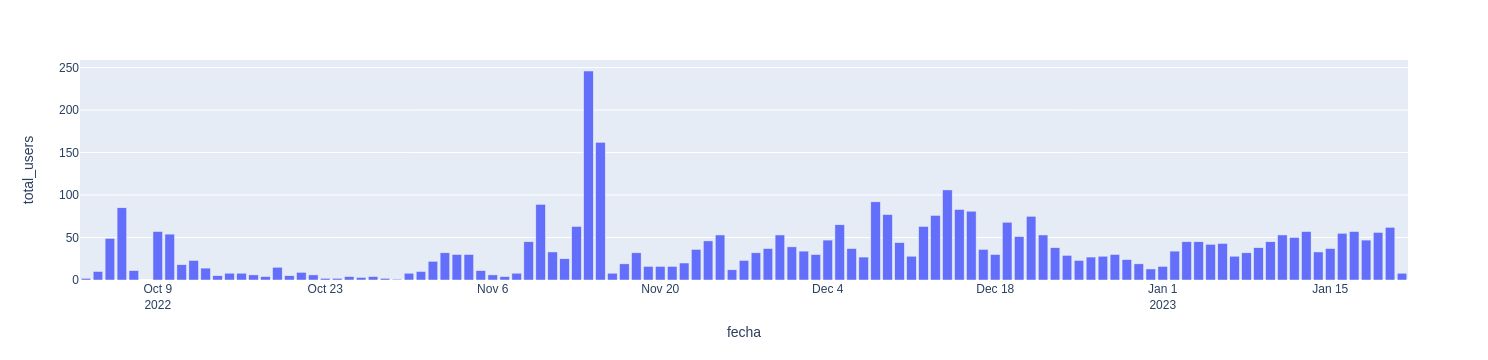

In [84]:
fig = px.bar(txs_by_day_df.dropna(), x='fecha', y='total_users')
fig.show()

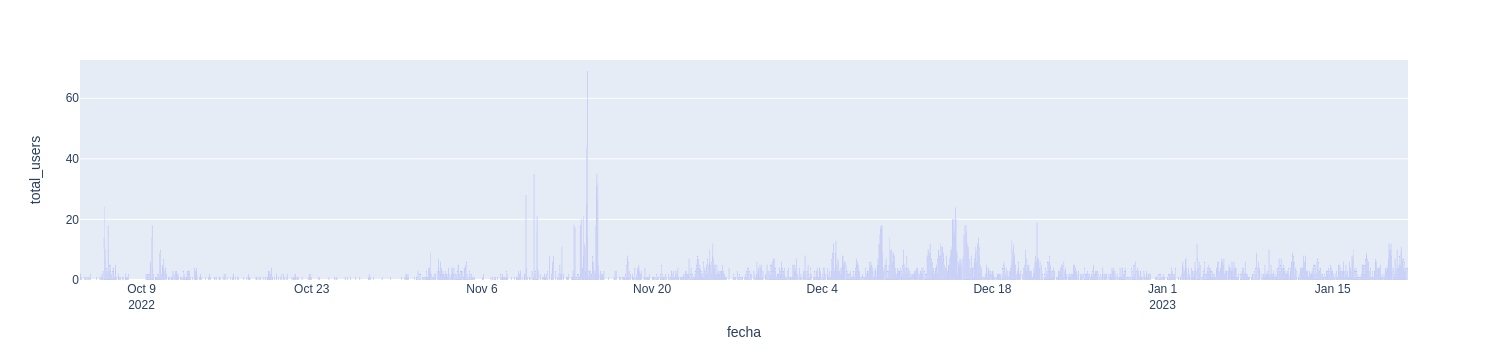

In [85]:
fig = px.bar(txs_by_hour_df, x='fecha', y='total_users')
fig.show()

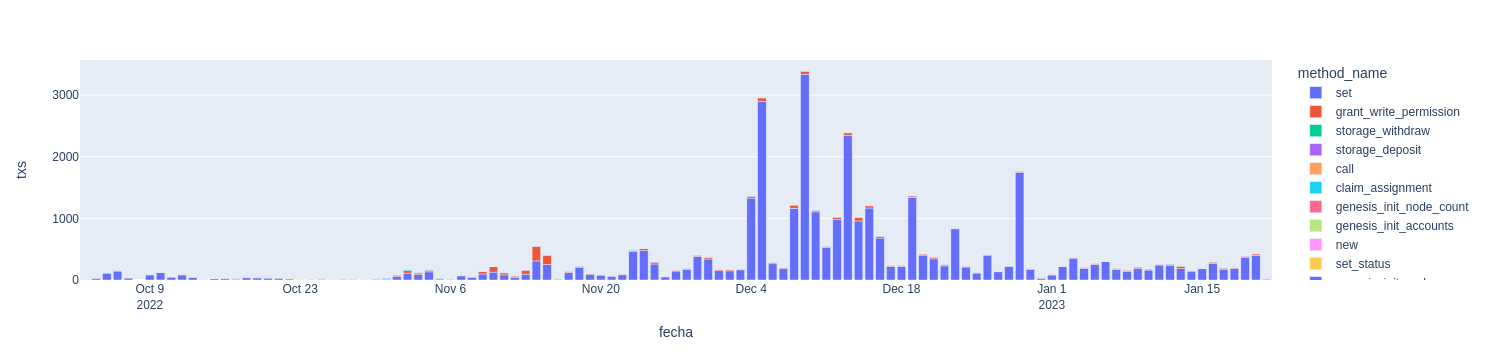

In [86]:
fig = px.bar(txs_by_day_and_method_df, x='fecha', y='txs',color='method_name')
fig.show()

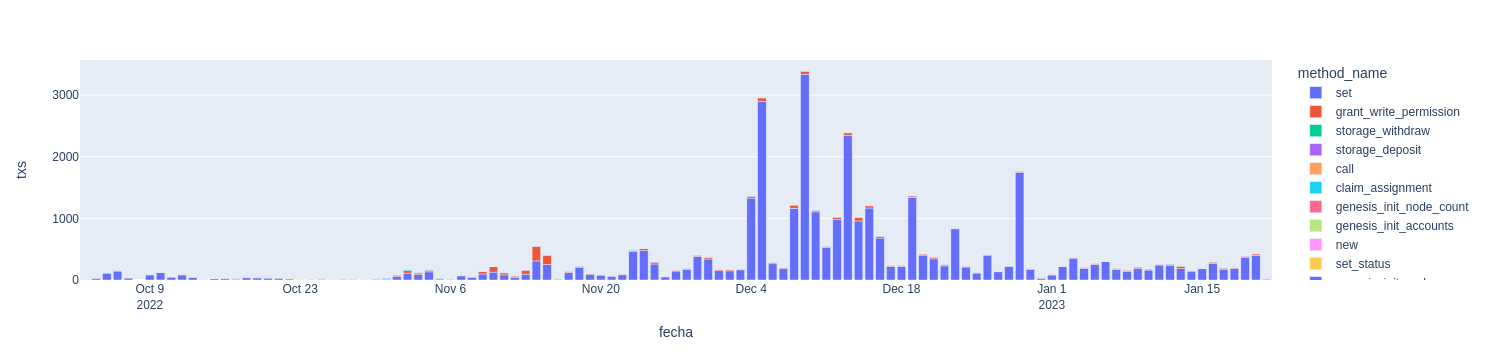

In [88]:
fig = px.bar(txs_by_day_and_method_df, x='fecha', y='txs',color='method_name')
fig.show()

In [87]:
near_price_df 

,fecha,daily_avg_price,daily_max_price,daily_min_price
0,2021-10-22,9.037634,9.1777,8.9429
1,2021-10-23,9.124934,9.4214,8.8348
2,2021-10-24,9.457656,9.9255,9.1490
3,2021-10-25,11.343649,12.6987,9.5534
4,2021-10-26,12.374959,13.1875,11.8386
...,...,...,...,...
453,2023-01-18,2.114361,2.2262,1.9578
454,2023-01-19,2.056985,2.1566,1.9726
455,2023-01-20,2.134951,2.4047,2.0496
456,2023-01-21,2.371462,2.3901,2.3562


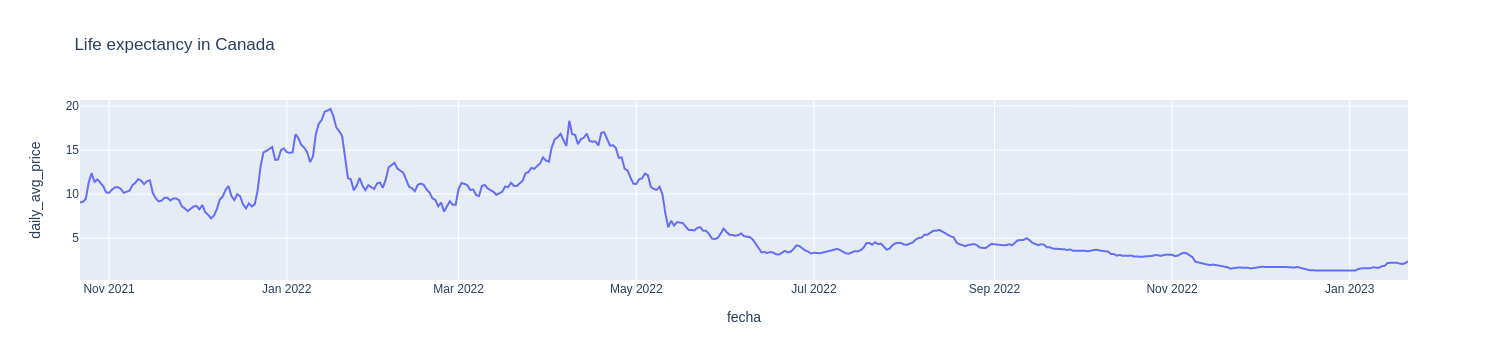

In [92]:
fig = px.line(near_price_df, x="fecha", y="daily_avg_price", title='Life expectancy in Canada')
#fig = px.line(near_price_df, x="fecha", y="daily_max_price", title='Life expectancy in Canada')
fig.show()

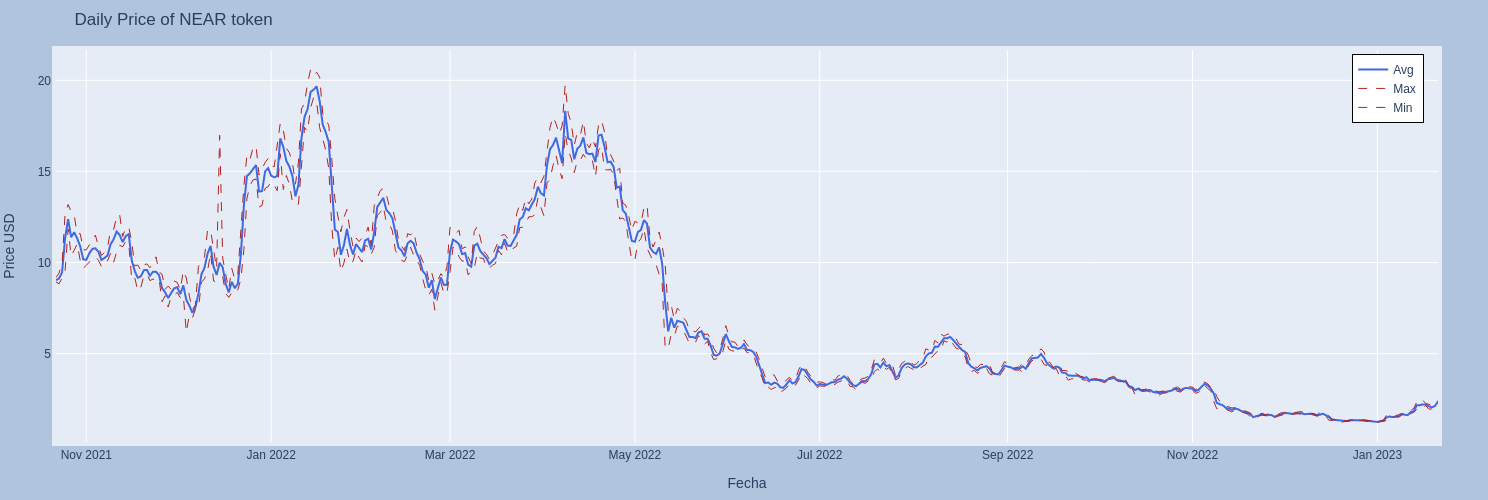

In [121]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=near_price_df['fecha'], y=near_price_df['daily_avg_price'],name='Avg',
                         line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=near_price_df['fecha'], y=near_price_df['daily_max_price'],name='Max',
                         line=dict(color='firebrick', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=near_price_df['fecha'], y=near_price_df['daily_min_price'],name='Min',
                         line=dict(color='firebrick', width=1, dash='dash')))


# Edit the layout
fig.update_layout(title='Daily Price of NEAR token',
                  xaxis_title='Fecha',
                  yaxis_title='Price USD',
                  autosize=False,
                  width=750,
                  height=500,
                  margin=dict(l=50,
                              r=50,
                              b=50, 
                              t=50,
                              pad=4
                             ),
                  paper_bgcolor="LightSteelBlue",
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="right",
                              x=0.99,
                              bgcolor="white",
                              bordercolor="black",
                              borderwidth=1
                             )
                 )


fig.show()